<a href="https://colab.research.google.com/github/parishamaheshj18/Applied-Linear-Systems-final-project/blob/master/multiclass_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Experiment with 17 Classes on low data regime


In [ ]:
# Before running this code check if the runtime is set to gpu. Click on Runtime -> Change runtime type -> select"GPU"
# Also donwload the dataset from https://www.kaggle.com/hung20736/kitti-by-ah-and-gf and upload it to google drive. 
# Next step is to connect google drive to collab file. Click on the folder icon on the left most bar and connect to your drive where the data is stored.
#!pip install tensorflow-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/data' # change this path according to the data location in your drive.

In [ ]:
!nvidia-smi

Thu Oct 21 17:08:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, Conv2DTranspose, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import warnings
from PIL import Image
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
 


# Data Preparation


In [ ]:

input_file_path = data_path+'rwth_kitti_semantics_dataset/images'
output_file_path = data_path+'rwth_kitti_semantics_dataset/labels_new'

os.chdir(data_path)
if os.path.isdir('train') is False:
  os.makedirs('train/images')
  os.makedirs('test/images')
  os.makedirs('validate/images')
  os.makedirs('train/labels')
  os.makedirs('test/labels')
  os.makedirs('validate/labels')
  os.mkdir('pics')
  for c in random.sample(glob.glob(input_file_path+'/*'),146):
    shutil.copy(c,'train/images')
  for c in random.sample(glob.glob(input_file_path+'/*'),42):
    shutil.copy(c,'test/images')
  for c in random.sample(glob.glob(input_file_path+'/*'),20):
    shutil.copy(c,'validate/images')
  for image_name in os.listdir('train/images'):
    shutil.copy(os.path.join(output_file_path,image_name),'train/labels')
  for image_name in os.listdir('test/images'):
    shutil.copy(os.path.join(output_file_path,image_name),'test/labels')  
  for image_name in os.listdir('validate/images'):
    shutil.copy(os.path.join(output_file_path,image_name),'validate/labels')
#os.chdir('../../')

In [ ]:
train_path = 'train'
test_path = 'test'
validate_path = 'validate'
HEIGHT = 128
WIDTH = 128
n_classes = 17
color_dict = {0: (0,   0, 255), #Car
              1: (255, 0,   0), #Road
              2: (255, 255,   0), #MArk
              3: (0,255,   0), #Building
              4: (255, 0,   255),#Sidewalk
              5: (0, 255,   255),#Tree/Bush
              6: (255, 0,   153),#Pole
              7: (153, 0,   255),#Sign
              8: (0, 153,   255),#Person
              9: (153,255,   0),#Wall
              10: (255, 153,   0),#Sky
              11: (0, 255,   153),#Curb
              12: (0, 153,   153),#Grass/Dirt
              13: (0, 0,   0),#Void
              14: (153, 153,   153),#Side Rail
              15: (0, 0,   153),#Object
              16: (255, 255,  153),#Bicycle/Motorbike
              }
def rgb_to_onehot(rgb_arr, color_dict):
    n_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(n_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr


In [ ]:
# Preparing training data:
train_ip_folder = train_path + '/images'
train_op_folder = train_path + '/labels'
train_ip_filelist = glob.glob(train_ip_folder+'/*')  
train_op_filelist = glob.glob(train_op_folder+'/*')  
train_ip_data = np.array([ cv2.resize(np.array(Image.open(fname)),(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC) for fname in train_ip_filelist],dtype=object)

im = np.array(Image.open(train_op_filelist[0]))
im = cv2.resize(im,(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
#train_op_data_sample = np.zeros((im.shape[0], im.shape[1], n_classes))
#train_op_data = np.zeros((HEIGHT,WIDTH,n_classes))
train_op_data_sample = rgb_to_onehot(im,color_dict)
train_op_data = train_op_data_sample[None,...]

for j in range(1,len(train_ip_filelist)):
  im = np.array(Image.open(train_op_filelist[j]))
  im = cv2.resize(im,(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
  #train_op_data_sample = np.zeros((im.shape[0], im.shape[1], n_classes))
  train_op_data_sample = rgb_to_onehot(im,color_dict)
  #op_data=np.dstack((op_data,op_data_sample))
  train_op_data=np.concatenate([train_op_data, train_op_data_sample[None,...]], axis=0)


In [ ]:
# Preparing testing data:
test_ip_folder = test_path + '/images'
test_op_folder = test_path + '/labels'
test_ip_filelist = glob.glob(test_ip_folder+'/*')  
test_op_filelist = glob.glob(test_op_folder+'/*')  
test_ip_data = np.array([ cv2.resize(np.array(Image.open(fname)),(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC) for fname in test_ip_filelist],dtype=object)

im = np.array(Image.open(test_op_filelist[0]))
im = cv2.resize(im,(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
#test_op_data_sample = np.zeros((im.shape[0], im.shape[1], n_classes))
#test_op_data = np.zeros((HEIGHT,WIDTH,n_classes))
test_op_data_sample = rgb_to_onehot(im,color_dict)
test_op_data = test_op_data_sample[None,...]

for j in range(1,len(test_ip_filelist)):
  im = np.array(Image.open(test_op_filelist[j]))
  im = cv2.resize(im,(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
  #test_op_data_sample = np.zeros((im.shape[0], im.shape[1], n_classes))
  test_op_data_sample = rgb_to_onehot(im,color_dict)
  #op_data=np.dstack((op_data,op_data_sample))
  test_op_data=np.concatenate([test_op_data, test_op_data_sample[None,...]], axis=0)


In [ ]:
print(train_op_data.shape)
print(train_ip_data.shape)

(146, 128, 128, 17)
(146, 128, 128, 3)


In [ ]:
print(test_op_data.shape)
print(test_ip_data.shape)

(42, 128, 128, 17)
(42, 128, 128, 3)


In [ ]:
print(np.amax(train_op_data))
print(np.amax(train_ip_data))
print(np.amin(test_op_data))
print(np.amin(test_ip_data))

1
255
0
0


# Training Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
EPOCHS = 200

def convolution_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)
    return x

def encoder(input, num_filters):
    s = convolution_block(input, num_filters)
    p = MaxPool2D((2, 2))(s)
    return s, p   

def decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder(inputs, 64)
    s2, p2 = encoder(p1, 128)
    s3, p3 = encoder(p2, 256)
    s4, p4 = encoder(p3, 512)

    b1 = convolution_block(p4, 1024) #Bridge

    d1 = decoder(b1, s4, 512)
    d2 = decoder(d1, s3, 256)
    d3 = decoder(d2, s2, 128)
    d4 = decoder(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model
   

model = unet((HEIGHT,WIDTH,3), n_classes=17)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [ ]:
train_ip_data=np.asarray(train_ip_data).astype(np.float32)
train_op_data=np.asarray(train_op_data).astype(np.float32)
test_ip_data=np.asarray(test_ip_data).astype(np.float32)
test_op_data=np.asarray(test_op_data).astype(np.float32)


In [ ]:

history = model.fit(train_ip_data,train_op_data , 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=EPOCHS, 
                    validation_data=(np.asarray(test_ip_data).astype(np.float32), np.asarray(test_op_data).astype(np.float32)),
                    shuffle=False)

Epoch 1/200
10/10 [==============================] - 23s 345ms/step - loss: 2.1705 - accuracy: 0.3558 - val_loss: 2115.9949 - val_accuracy: 0.1138
Epoch 2/200
10/10 [==============================] - 1s 136ms/step - loss: 1.4034 - accuracy: 0.5973 - val_loss: 24428.4219 - val_accuracy: 0.1672
Epoch 3/200
10/10 [==============================] - 1s 137ms/step - loss: 1.1403 - accuracy: 0.6491 - val_loss: 25944.3965 - val_accuracy: 0.2616
Epoch 4/200
10/10 [==============================] - 1s 139ms/step - loss: 1.0215 - accuracy: 0.6721 - val_loss: 7529.3438 - val_accuracy: 0.2332
Epoch 5/200
10/10 [==============================] - 1s 137ms/step - loss: 0.9312 - accuracy: 0.6897 - val_loss: 1166.7552 - val_accuracy: 0.2226
Epoch 6/200
10/10 [==============================] - 1s 133ms/step - loss: 0.8467 - accuracy: 0.7141 - val_loss: 406.9404 - val_accuracy: 0.2809
Epoch 7/200
10/10 [==============================] - 1s 139ms/step - loss: 0.7929 - accuracy: 0.7235 - val_loss: 140.5805 

In [ ]:
model.save('/content/drive/MyDrive/Advanced Machine Learning/saved_models/KITTI_'+str(EPOCHS)+'epochs.hdf5')

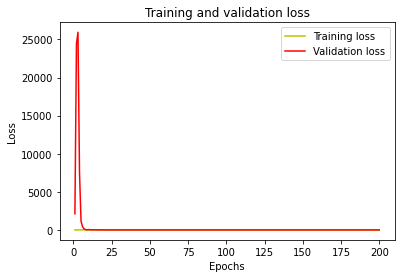

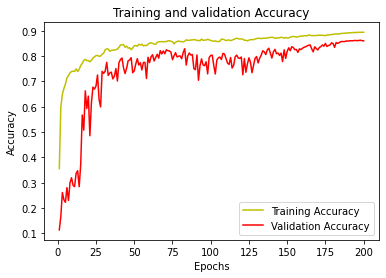

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Validation

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Advanced Machine Learning/saved_models/KITTI_"+str(EPOCHS)+"epochs.hdf5", compile=False)

In [ ]:
validate_ip_folder = validate_path + '/images'
validate_op_folder = validate_path + '/labels'
validate_ip_filelist = glob.glob(validate_ip_folder+'/*')  
validate_op_filelist = glob.glob(validate_op_folder+'/*')  
validate_ip_data = np.array([ cv2.resize(np.array(Image.open(fname)),(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC) for fname in validate_ip_filelist],dtype=object)

im = np.array(Image.open(validate_op_filelist[0]))
im = cv2.resize(im,(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
validate_op_data_sample = rgb_to_onehot(im,color_dict)
validate_op_data = validate_op_data_sample[None,...]

for j in range(1,len(validate_ip_filelist)):
  im = np.array(Image.open(validate_op_filelist[j]))
  im = cv2.resize(im,(WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
  validate_op_data_sample = rgb_to_onehot(im,color_dict)
  #op_data=np.dstack((op_data,op_data_sample))
  validate_op_data=np.concatenate([validate_op_data, validate_op_data_sample[None,...]], axis=0)


In [ ]:
validate_ip_data=np.asarray(validate_ip_data).astype(np.float32)
validate_pred=model.predict(np.asarray(validate_ip_data).astype(np.float32))
y_pred_argmax=np.argmax(validate_pred, axis=3)
y_pred_argmax.shape

(20, 128, 128)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 17
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(validate_op_data[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.00057203026


EPOCHS :  200
Random image number:  19
Input shape:  (128, 128, 3)
Ground truth shape:  (128, 128, 17)


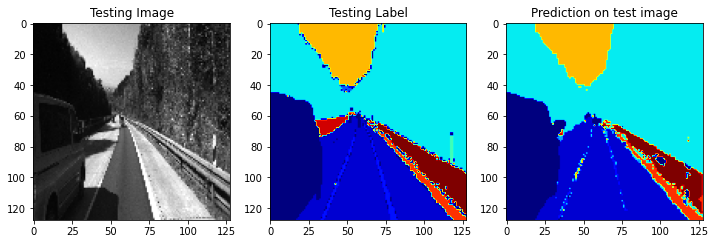

In [ ]:
import random
print("EPOCHS : ", EPOCHS)
test_img_number = random.randint(0, len(validate_ip_filelist)-1)
print("Random image number: ", test_img_number)
test_img = validate_ip_data[test_img_number,:,:,:]
print("Input shape: ",test_img.shape)
ground_truth=validate_op_data[test_img_number,:,:,:]
print("Ground truth shape: ", ground_truth.shape)


ground_truth_img=np.argmax(ground_truth, axis=2)

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))

predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_img, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

EPOCHS :  200
Random image number:  9
Input shape:  (128, 128)
Ground truth shape:  (128, 128)
max value of input img:  255.0
max value of groundtruth:  1.0
max value of predicted img:  1.0


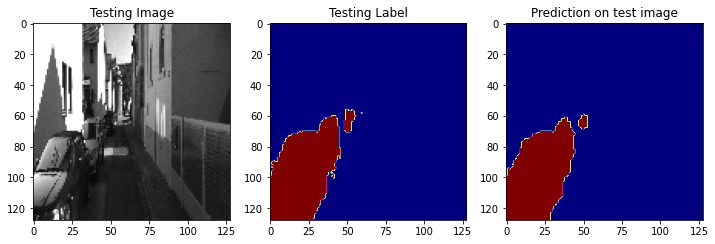

In [ ]:
import random
print("EPOCHS : ", EPOCHS)
test_img_number = random.randint(0, len(test_ip_filelist)-1)
test_img = test_ip_data[test_img_number,:,:,:]
ground_truth=test_op_data[test_img_number,:,:,:]
ground_truth_img=ground_truth[:,:,0]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=prediction[:,:,:,0]
predicted_img[predicted_img>0.5]=1
predicted_img[predicted_img<=0.5]=0
print("Random image number: ", test_img_number)
print("Input shape: ",test_img[:,:,0].shape)
print("Ground truth shape: ", ground_truth_img.shape)
print("max value of input img: ", np.amax(test_img[:,:,0]))
print("max value of groundtruth: ", np.amax(ground_truth_img))
print("max value of predicted img: ", np.amax(predicted_img))
predicted_img=predicted_img[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_img, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
np.amax(predicted_img)
predicted_img[predicted_img>0.5]=1
np.amin(predicted_img)


0.0

f1 score:  0


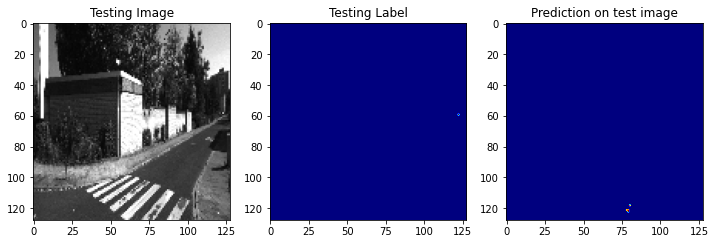

f1 score:  0.10279001468428782


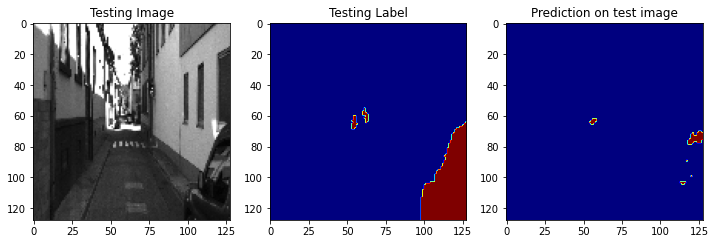

f1 score:  0.9168975069252079


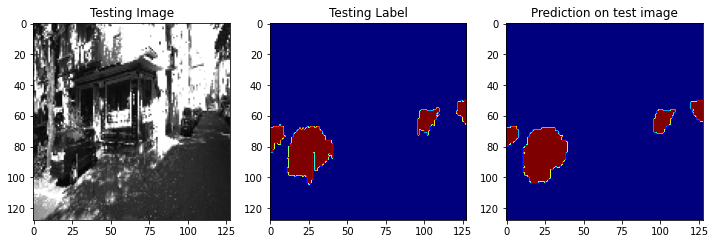

f1 score:  0.5142150803461063


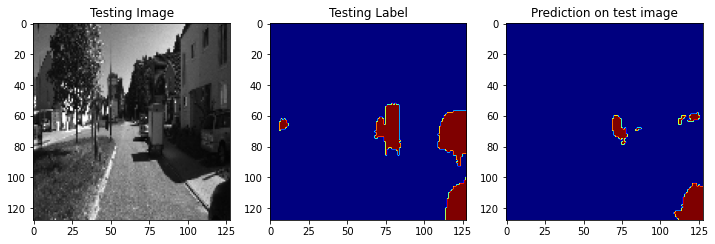

f1 score:  0


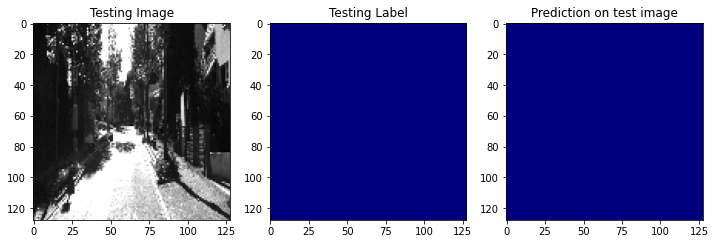

f1 score:  0


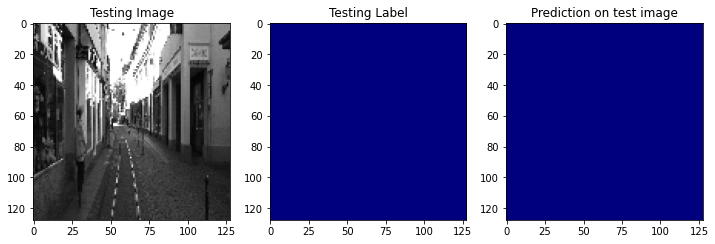

f1 score:  0.5561083471531233


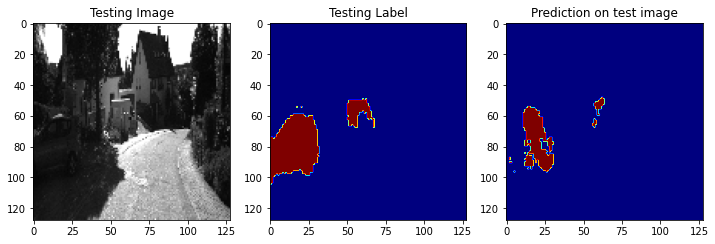

f1 score:  0.8993364928909953


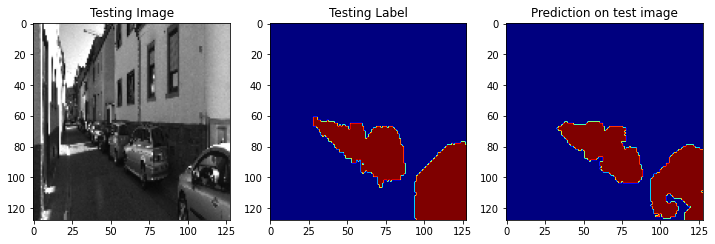

f1 score:  0.8952007835455437


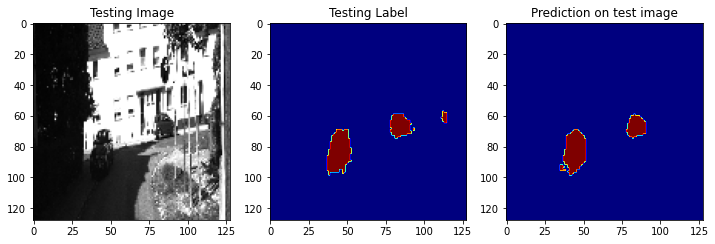

f1 score:  0.9515680089070327


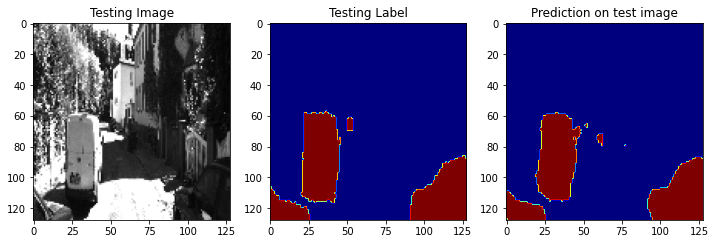

f1 score:  0


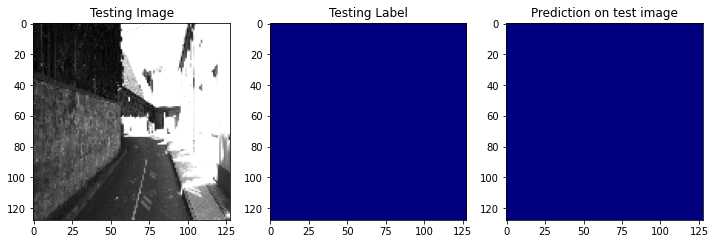

f1 score:  0.8024357239512856


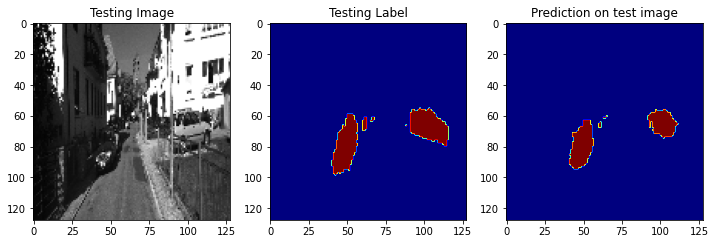

f1 score:  0.9853264009243212


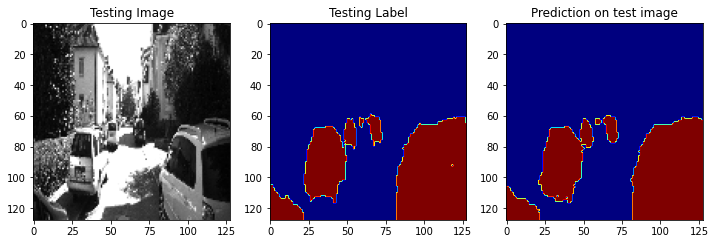

f1 score:  0.8021978021978022


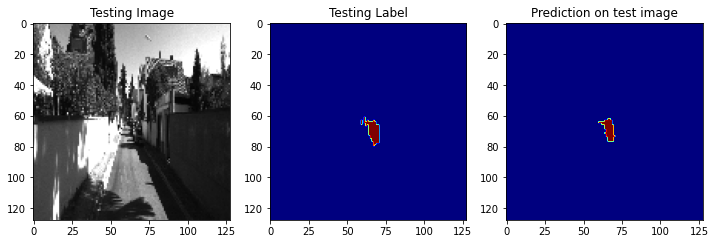

f1 score:  0


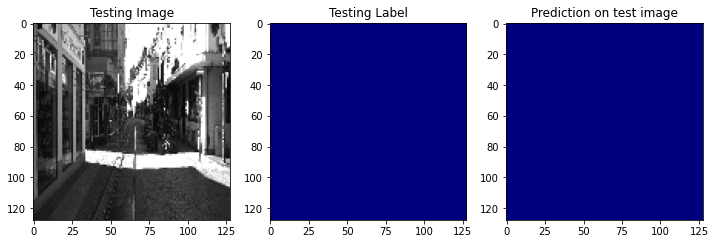

f1 score:  0.6871794871794872


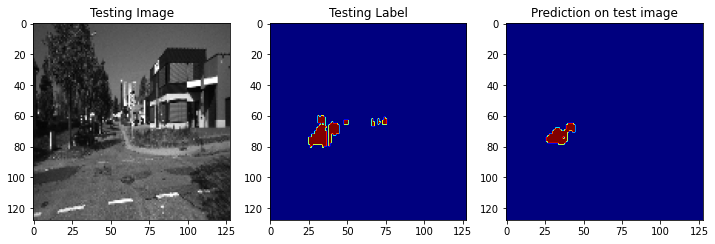

f1 score:  0.9116279069767441


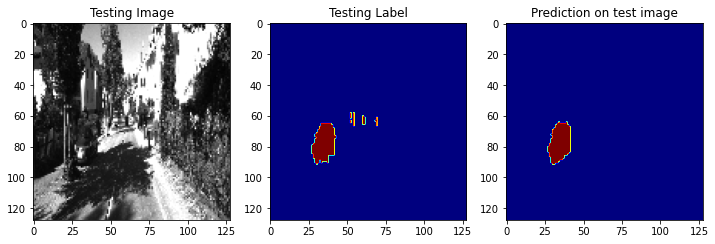

f1 score:  0


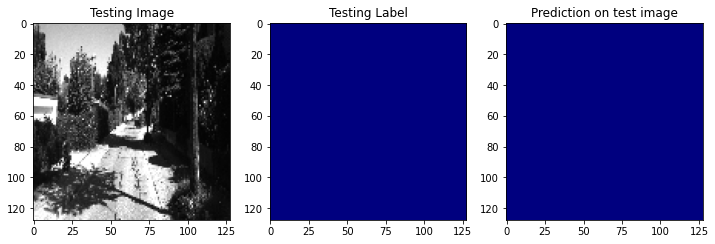

f1 score:  0


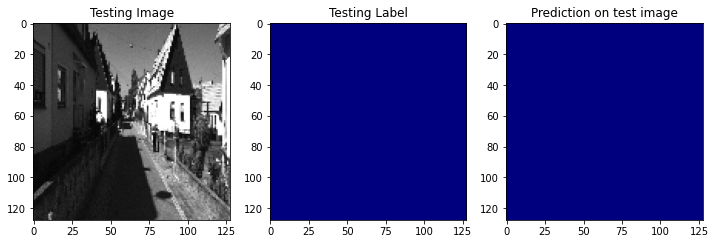

f1 score:  0.9696969696969697


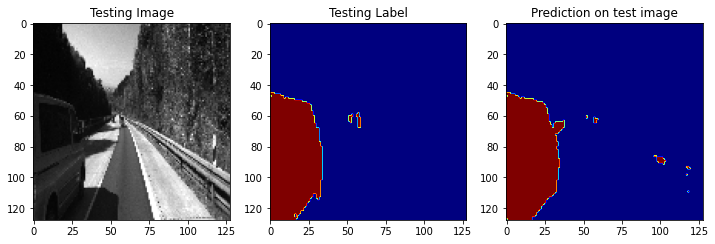

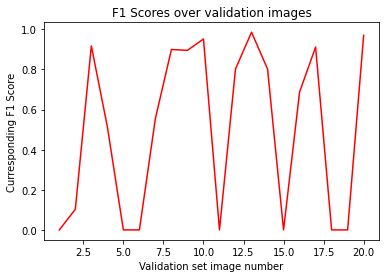

In [ ]:
from keras import backend as K
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def perf_measure(y_actual, y_hat):
    y_actual = y_actual.flatten()
    y_hat=y_hat.flatten()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_actual)): 
        if np.array([y_actual[i]==1, y_hat[i]==1]).all():
           TP += 1
        if np.array([y_hat[i]==1 , y_actual[i]!=y_hat[i]]).all():
           FP += 1
        if np.array([y_actual[i]==0 , y_hat[i]==0]).all():
           TN += 1
        if np.array([y_hat[i]==0 , y_actual[i]!=y_hat[i]]).all():
           FN += 1
    return(TP, FP, TN, FN)

def precision(metrics):
    TP = metrics[0]
    FP = metrics[1]
    if TP+FP == 0:
        r= 0
    else:
        r= TP/(TP+FP)
    return r

def recall(metrics):
    TP = metrics[0]
    FN = metrics[3]
    if TP+FN == 0:
        r= 0
    else:
        r= TP/(TP+FN)
    return r

def F1_Score(y_actual,y_hat):
  metrics = perf_measure(y_actual, y_hat)
  prec = precision(metrics)
  rec = recall(metrics)
  if prec+rec==0:
    return 0
  else:
    return (2*prec*rec)/(prec+rec)
  
lenght_of_list = len(validate_ip_filelist)
f1_scores_list = np.zeros(lenght_of_list)

for i in range(lenght_of_list):
  test_img_number = i
  test_img = validate_ip_data[test_img_number,:,:,:]
  ground_truth=validate_op_data[test_img_number,:,:,:]
  ground_truth_img=ground_truth[:,:,0]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=prediction[:,:,:,0]
  predicted_img[predicted_img>0.5]=1
  predicted_img[predicted_img<=0.5]=0
  predicted_img=predicted_img[0,:,:]
  ground_truth_img = np.asarray(ground_truth_img).astype(np.uint8)
  predicted_img = np.asarray(predicted_img).astype(np.uint8)
  f1_score = F1_Score(ground_truth_img,predicted_img)
  print("f1 score: ", f1_score)
  #print("Image number: ", test_img_number)
  #print("Input shape: ",test_img[:,:,0].shape)
  #print("Ground truth shape: ", ground_truth_img.shape)
  #print("max value of input img: ", np.amax(test_img[:,:,0]))
  #print("max value of groundtruth: ", np.amax(ground_truth_img))
  #print("max value of predicted img: ", np.amax(predicted_img))
  f1_scores_list[i] = f1_score
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth_img, cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()



x = np.arange(1, lenght_of_list+1)
y = f1_scores_list
 
# plotting
plt.title("F1 Scores over validation images")
plt.xlabel("Validation set image number")
plt.ylabel("Curresponding F1 Score")
plt.plot(x, y, color ="red")
plt.show()